In [1]:
from datetime import date
from enum import Enum

%load_ext google.cloud.bigquery
from google.cloud import bigquery


In [2]:
project = "celo-testnet"
client = bigquery.Client(project)
for dataset in client.list_datasets():
    print(dataset.dataset_id)

dataflow_metrics
load_test_data
segment_data
segment_data_events
segment_data_metrics
transaction_data
transaction_metrics_exporter


In [3]:
partition = date.today().strftime("%Y%m%d")
# partition = 20200316
# partition = "*"
dataset = "transaction_metrics_exporter"
table = "transaction_metrics_exporter_{0}".format(partition)
tme = client.get_dataset(dataset)
table_path = ".".join([project, dataset, table])
print(table_path)

celo-testnet.transaction_metrics_exporter.transaction_metrics_exporter_20200318


In [4]:
class EventTypes(Enum):
    RECEIVED_BLOCK="RECEIVED_BLOCK"
    RECEIVED_STATE="RECEIVED_STATE"
    RECEIVED_TRANSACTION="RECEIVED_TRANSACTION"
    RECEIVED_TRANSACTION_RECEIPT="RECEIVED_TRANSACTION_RECEIPT"
    RECEIVED_PARSED_TRANSACTION="RECEIVED_PARSED_TRANSACTION"
    RECEIVED_PARSED_LOG="RECEIVED_PARSED_LOG"

In [5]:
query_blocks = f"""
WITH 
  unique_blockNumbers AS (
    SELECT 
      DISTINCT jsonPayload.number AS number,
      timestamp as timestamp
    FROM 
      `{table_path}`
    WHERE 
      jsonPayload.event='{EventTypes.RECEIVED_BLOCK.value}' 
  )
SELECT 
  MAX(T.timestamp) as timestamp,
  T.jsonPayload.number as blockNumber,
  MAX(T.jsonPayload.gasUsed) as gasUsed,
  MAX(T.jsonPayload.gasLimit) as gasLimit,
  COUNT(T.jsonPayload.transactions) as txAmount
FROM 
  `{table_path}` as T
INNER JOIN unique_blockNumbers 
ON 
  T.jsonPayload.number = unique_blockNumbers.number
  AND T.timestamp > unique_blockNumbers.timestamp
  AND T.jsonPayload.event='{EventTypes.RECEIVED_BLOCK.value}'
GROUP BY blockNumber
ORDER BY blockNumber DESC 
"""

df_blocks = client.query(
    query_blocks, 
    job_config=bigquery.QueryJobConfig(
        query_parameters=[]
    )
).to_dataframe()

df_blocks.describe()

,blockNumber,gasUsed,gasLimit,txAmount
count,9.267000e+03,9267.000000,9267.0,9267.0
mean,1.122436e+06,99794.169310,20000000.0,1.0
std,2.675297e+03,77997.944297,0.0,0.0
min,1.117803e+06,0.000000,20000000.0,1.0
25%,1.120120e+06,41069.000000,20000000.0,1.0
50%,1.122436e+06,82138.000000,20000000.0,1.0
75%,1.124752e+06,120432.000000,20000000.0,1.0
max,1.127069e+06,884992.000000,20000000.0,1.0


In [6]:
df_blocks.head()

,timestamp,blockNumber,gasUsed,gasLimit,txAmount
0,2020-03-18 14:59:40.641698+00:00,1127069.0,108726.0,20000000.0,1
1,2020-03-18 14:59:35.663730+00:00,1127068.0,91069.0,20000000.0,1
2,2020-03-18 14:59:30.546685+00:00,1127067.0,79363.0,20000000.0,1
3,2020-03-18 14:59:25.566561+00:00,1127066.0,353264.0,20000000.0,1
4,2020-03-18 14:59:20.585623+00:00,1127065.0,91069.0,20000000.0,1


In [7]:
last_block, first_block = df_blocks.blockNumber.max(), df_blocks.blockNumber.min()
print(f"last block  : {last_block:.0f} on {df_blocks.timestamp.max()}") 
print(f"first block : {first_block:.0f} on {df_blocks.timestamp.min()}")
print(f"blocks load : {(last_block - first_block):.0f}")
print(f"transactions: {df_blocks.txAmount.sum()}")
print(f"mean gasUsed: {df_blocks.gasUsed.mean():.0f} GcWei")

last block  : 1127069 on 2020-03-18 14:59:40.641698+00:00
first block : 1117803 on 2020-03-18 00:00:04.535886+00:00
blocks load : 9266
transactions: 9267
mean gasUsed: 99794 GcWei


In [8]:
query_state = f"""
SELECT
  timestamp,
  jsonPayload.blockNumber,
  jsonPayload.contract,
  jsonPayload.function,
  jsonPayload.medianRate,
  jsonPayload.currentStableBucket,
  jsonPayload.currentGoldBucket,
  jsonPayload.goldTokenTotalSupply
FROM 
  `{table_path}` as T
WHERE 
  jsonPayload.event='{EventTypes.RECEIVED_STATE.value}'
ORDER BY 
  T.jsonPayload.blockNumber DESC,
  T.timestamp DESC
"""

df_state = client.query(
    query_state, 
    job_config=bigquery.QueryJobConfig(
        query_parameters=[]
    )
).to_dataframe()

df_state.describe()

,blockNumber,medianRate,currentStableBucket,currentGoldBucket,goldTokenTotalSupply
count,5.560800e+04,18536.000000,1.853600e+04,1.853600e+04,1.853600e+04
mean,1.122436e+06,1.001275,3.349637e+24,1.995523e+24,2.209795e+26
std,2.675465e+03,0.000810,2.795917e+24,4.185405e+23,2.708855e+23
min,1.117803e+06,1.000000,2.166860e+24,1.000000e+24,2.205189e+26
25%,1.120120e+06,1.001000,2.171766e+24,2.167955e+24,2.207379e+26
50%,1.122436e+06,1.001000,2.176675e+24,2.170691e+24,2.209749e+26
75%,1.124753e+06,1.002000,2.179412e+24,2.173423e+24,2.212116e+26
max,1.127070e+06,1.003000,1.000000e+25,2.176153e+24,2.214483e+26


In [9]:
df_state.head()

,timestamp,blockNumber,contract,function,medianRate,currentStableBucket,currentGoldBucket,goldTokenTotalSupply
0,2020-03-18 14:59:45.628138+00:00,1127070.0,Exchange,getBuyAndSellBuckets,NaN,2.180506e+24,2.176153e+24,NaN
1,2020-03-18 14:59:45.627610+00:00,1127070.0,GoldToken,totalSupply,NaN,NaN,NaN,2.214483e+26
2,2020-03-18 14:59:45.627601+00:00,1127070.0,SortedOracles,medianRate,1.002,NaN,NaN,NaN
3,2020-03-18 14:59:45.627538+00:00,1127070.0,SortedOracles,medianRate,1.002,NaN,NaN,NaN
4,2020-03-18 14:59:45.627529+00:00,1127070.0,Exchange,getBuyAndSellBuckets,NaN,2.180506e+24,2.176153e+24,NaN


Text(0, 0.5, 'SortedOracles.medianRate')

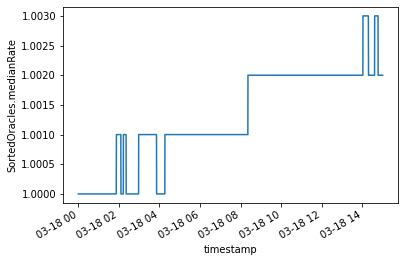

In [10]:
df_sortedOracles = df_state.set_index('timestamp')['medianRate'].dropna()
ax = df_sortedOracles.plot()
ax.set_xlabel("timestamp")
ax.set_ylabel("SortedOracles.medianRate")

Text(0.5, 0, 'timestamp')

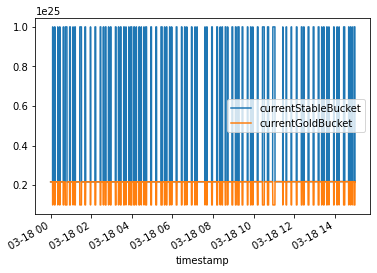

In [11]:
df_stableToken = df_state.set_index('timestamp')[['currentStableBucket','currentGoldBucket']].dropna()
ax = df_stableToken.plot()
ax.set_xlabel("timestamp")

Text(0.5, 0, 'timestamp')

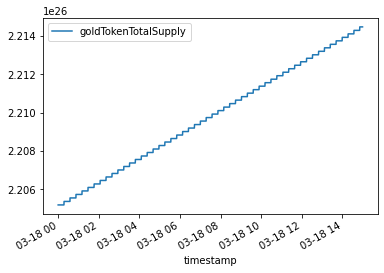

In [12]:
df_goldToken = df_state.set_index('timestamp')[['goldTokenTotalSupply']].dropna()
ax = df_goldToken.plot()
ax.set_xlabel("timestamp")